# MLP 구현
시계열 데이터의 패턴을 학습하여 다음 값 6개를 예측하는 모델
* 데이터 : Champagne_Sales.csv
* input : 현재+과거 12개월 판매량
* output : 다음 6개월 판매량

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
# univariate mlp example
import warnings
warnings.filterwarnings('ignore')
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

%matplotlib inline

Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

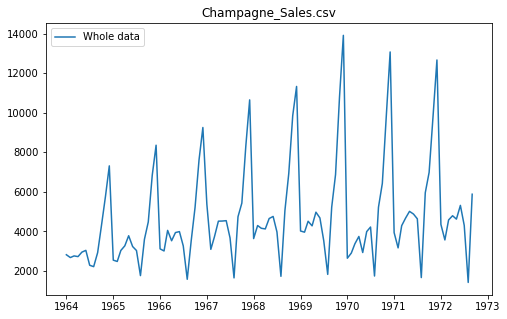

<Figure size 432x288 with 0 Axes>

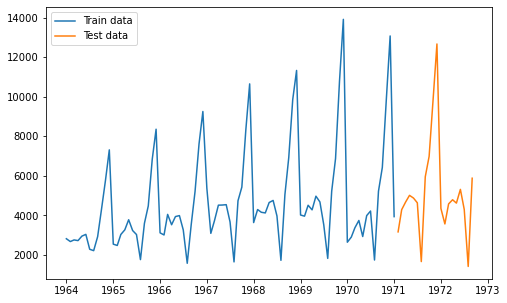

In [3]:
import pandas as pd
#import warnings
#warnings.filterwarnings('ignore')
from matplotlib import pyplot
%matplotlib inline

series = pd.read_csv('Champagne_Sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

pyplot.clf()
pyplot.figure(figsize=(8,5))
pyplot.title('Champagne_Sales.csv')
pyplot.plot(series, label="Whole data")
pyplot.legend(loc = 'upper left')
pyplot.show()

# train, test data 구분
train_data = series[:85]
test_data = series[-20:]

pyplot.clf()
pyplot.figure(figsize=(8,5))
pyplot.plot(train_data, label="Train data")
pyplot.plot(test_data, label="Test data")
pyplot.legend(loc = 'upper left')
pyplot.show()

## 학습 데이터 구성
sequence를 학습에 사용할 데이터로 변환
    * 입력 데이터(X)는 sequence에서 n_steps 단위로 분리하여 구성
    * 출력 데이터(y)는 입력 데이터 다음 순서에 오는 값

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, in_steps, out_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + in_steps
        # check if we are beyond the sequence
        if end_ix+out_steps > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+out_steps]
        X.append(seq_x)
        y.append(seq_y)
        
    return array(X), array(y)

In [5]:
# a number of input, output time steps
in_steps = 12
out_steps = 6

train_series = series[:85+out_steps]
test_series = series[-(20+in_steps):]

# split into train, test samples
train_X, train_y = split_sequence(train_series, in_steps, out_steps)
test_X, test_y = split_sequence(test_series, in_steps, out_steps)

## Train, Test 데이터 구성
* 전체 데이터 수 : 105개
* Train 데이터 수 : 73개
* Test 데이터 수 : 20개
* 이전 데이터 12개를 사용하여 다음 값을 예측하기에 전체 데이터 수와 (Train + Test 데이터 수)에 차이가 남

In [6]:
train_X.shape, test_X.shape

((73, 12), (14, 12))

In [7]:
train_X[-5:]

array([[ 5222,  6872, 10803, 13916,  2639,  2899,  3370,  3740,  2927,
         3986,  4217,  1738],
       [ 6872, 10803, 13916,  2639,  2899,  3370,  3740,  2927,  3986,
         4217,  1738,  5221],
       [10803, 13916,  2639,  2899,  3370,  3740,  2927,  3986,  4217,
         1738,  5221,  6424],
       [13916,  2639,  2899,  3370,  3740,  2927,  3986,  4217,  1738,
         5221,  6424,  9842],
       [ 2639,  2899,  3370,  3740,  2927,  3986,  4217,  1738,  5221,
         6424,  9842, 13076]], dtype=int64)

In [8]:
train_y[-5:]

array([[ 5221,  6424,  9842, 13076,  3934,  3162],
       [ 6424,  9842, 13076,  3934,  3162,  4286],
       [ 9842, 13076,  3934,  3162,  4286,  4676],
       [13076,  3934,  3162,  4286,  4676,  5010],
       [ 3934,  3162,  4286,  4676,  5010,  4874]], dtype=int64)

In [9]:
test_X[:5]

array([[ 2899,  3370,  3740,  2927,  3986,  4217,  1738,  5221,  6424,
         9842, 13076,  3934],
       [ 3370,  3740,  2927,  3986,  4217,  1738,  5221,  6424,  9842,
        13076,  3934,  3162],
       [ 3740,  2927,  3986,  4217,  1738,  5221,  6424,  9842, 13076,
         3934,  3162,  4286],
       [ 2927,  3986,  4217,  1738,  5221,  6424,  9842, 13076,  3934,
         3162,  4286,  4676],
       [ 3986,  4217,  1738,  5221,  6424,  9842, 13076,  3934,  3162,
         4286,  4676,  5010]], dtype=int64)

In [10]:
test_y[:5]

array([[3162, 4286, 4676, 5010, 4874, 4633],
       [4286, 4676, 5010, 4874, 4633, 1659],
       [4676, 5010, 4874, 4633, 1659, 5951],
       [5010, 4874, 4633, 1659, 5951, 6981],
       [4874, 4633, 1659, 5951, 6981, 9851]], dtype=int64)

In [11]:
train_y.shape, test_y.shape

((73, 6), (14, 6))

In [12]:
test_y

array([[ 3162,  4286,  4676,  5010,  4874,  4633],
       [ 4286,  4676,  5010,  4874,  4633,  1659],
       [ 4676,  5010,  4874,  4633,  1659,  5951],
       [ 5010,  4874,  4633,  1659,  5951,  6981],
       [ 4874,  4633,  1659,  5951,  6981,  9851],
       [ 4633,  1659,  5951,  6981,  9851, 12670],
       [ 1659,  5951,  6981,  9851, 12670,  4348],
       [ 5951,  6981,  9851, 12670,  4348,  3564],
       [ 6981,  9851, 12670,  4348,  3564,  4577],
       [ 9851, 12670,  4348,  3564,  4577,  4788],
       [12670,  4348,  3564,  4577,  4788,  4618],
       [ 4348,  3564,  4577,  4788,  4618,  5312],
       [ 3564,  4577,  4788,  4618,  5312,  4298],
       [ 4577,  4788,  4618,  5312,  4298,  1413]], dtype=int64)

In [13]:
train_y_1st = list(train_y[i][0] for i in range(train_y.shape[0]))
test_y_1st = list(test_y[i][0] for i in range(test_y.shape[0]))

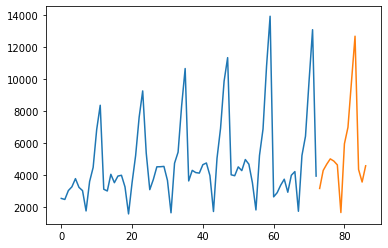

In [14]:
train_y_xticks = list(i for i in range(len(train_y_1st)))
pyplot.plot(train_y_xticks, train_y_1st)
test_y_xticks = list(len(train_y_1st)+i for i in range(len(test_y_1st)))
pyplot.plot(test_y_xticks, test_y_1st)
pyplot.show()

## MLP 모델 구성 : 12-75-6-1

In [15]:
# define model
model = Sequential()
model.add(Dense(75, activation='relu', input_dim=in_steps))
model.add(Dense(6))
model.compile(optimizer='adam', loss='mse')

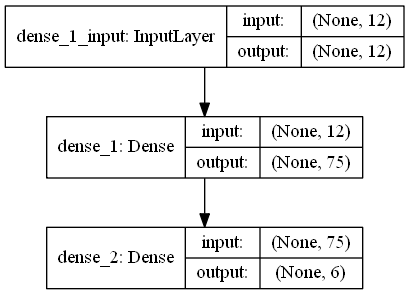

In [16]:
from keras.utils import plot_model

plot_model(model, show_shapes=True)

## 학습
* epochs를 200부터 2000까지 늘려가면서 비교해 볼 것
    * RMSE < 650, R2_score > 90 가능
    * 성능이 epochs에 비례하지는 않음

In [17]:
# fit model
learn_log = model.fit(train_X, train_y, epochs=210, validation_data=(test_X, test_y), verbose=0)

## Traing loss 확인

Epochs : 210


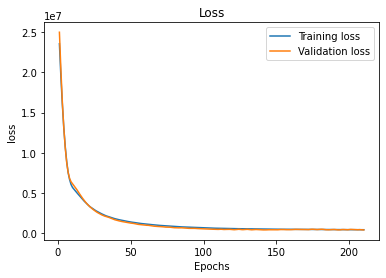

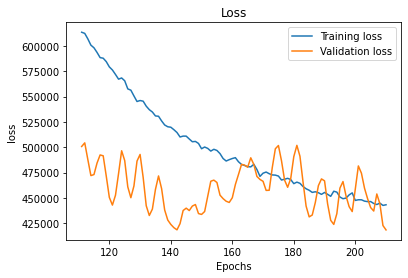

In [18]:
# training loss
loss = learn_log.history['loss']
# validation loss
val_loss = learn_log.history['val_loss']

epochs = range(1, len(loss) + 1)
print('Epochs : %d' % len(epochs))

# Loss 출력
pyplot.plot(epochs, loss, label='Training loss')
pyplot.plot(epochs, val_loss, label='Validation loss')
pyplot.title('Loss')
pyplot.xlabel('Epochs')
pyplot.ylabel('loss')
pyplot.legend()
pyplot.show()

# Loss의 마지막 부분 확대 출력
last_epochs = 100

pyplot.clf()
pyplot.plot(epochs[-last_epochs:], loss[-last_epochs:], label='Training loss')
pyplot.plot(epochs[-last_epochs:], val_loss[-last_epochs:], label='Validation loss')
pyplot.title('Loss')
pyplot.xlabel('Epochs')
pyplot.ylabel('loss')
pyplot.legend()
pyplot.show()

In [19]:
print('Training Loss(last 5):', loss[-5:])
print('Validation Loss(last 5):' , val_loss[-5:])

Training Loss(last 5): [444512.9871575342, 443472.72688356164, 444840.34589041094, 442598.8433219178, 443231.3788527397]
Validation Loss(last 5): [437062.96875, 453887.8125, 444197.84375, 422714.1875, 418415.1875]


## 예측

In [20]:
# prediction
prediction = model.predict(test_X, verbose=0)

In [21]:
test_y

array([[ 3162,  4286,  4676,  5010,  4874,  4633],
       [ 4286,  4676,  5010,  4874,  4633,  1659],
       [ 4676,  5010,  4874,  4633,  1659,  5951],
       [ 5010,  4874,  4633,  1659,  5951,  6981],
       [ 4874,  4633,  1659,  5951,  6981,  9851],
       [ 4633,  1659,  5951,  6981,  9851, 12670],
       [ 1659,  5951,  6981,  9851, 12670,  4348],
       [ 5951,  6981,  9851, 12670,  4348,  3564],
       [ 6981,  9851, 12670,  4348,  3564,  4577],
       [ 9851, 12670,  4348,  3564,  4577,  4788],
       [12670,  4348,  3564,  4577,  4788,  4618],
       [ 4348,  3564,  4577,  4788,  4618,  5312],
       [ 3564,  4577,  4788,  4618,  5312,  4298],
       [ 4577,  4788,  4618,  5312,  4298,  1413]], dtype=int64)

In [22]:
prediction

array([[ 3068.06  ,  3365.9915,  3244.1753,  3315.5608,  4216.0547,
         4024.4978],
       [ 3412.0178,  3914.7532,  3595.5188,  4200.5093,  4705.192 ,
         1740.7916],
       [ 3604.4377,  3252.2979,  3687.6404,  4842.9326,  1666.3917,
         5745.3525],
       [ 3041.2244,  3586.786 ,  4757.8125,  1909.18  ,  5839.5654,
         6729.437 ],
       [ 4470.156 ,  4250.734 ,  1741.6569,  5758.329 ,  7129.563 ,
        10520.304 ],
       [ 4654.3657,  1709.6664,  5698.979 ,  6955.0156, 10162.323 ,
        13302.277 ],
       [ 1988.7988,  5347.1914,  6905.43  , 10727.281 , 13439.008 ,
         4605.3574],
       [ 5406.6875,  6673.1104, 10301.061 , 13636.459 ,  4065.7275,
         3466.6653],
       [ 7087.379 , 10337.857 , 13935.206 ,  4622.678 ,  3347.501 ,
         4342.897 ],
       [10451.352 , 13915.45  ,  4191.4756,  3260.4626,  4111.682 ,
         4755.5576],
       [13790.819 ,  4273.7827,  3453.095 ,  4843.2427,  4357.088 ,
         5202.1484],
       [ 3819.5876,  

## 실제 값과 예측 값 비교

In [23]:
diff_y = list(test_y[i] - prediction[i] for i in range(len(test_y)))
diff_y

[array([  93.93994141,  920.00854492, 1431.82470703, 1694.43920898,
         657.9453125 ,  608.50219727]),
 array([ 873.98217773,  761.24682617, 1414.48120117,  673.49072266,
         -72.19189453,  -81.79162598]),
 array([1071.56225586, 1757.70214844, 1186.35961914, -209.93261719,
          -7.39172363,  205.64746094]),
 array([1968.77563477, 1287.21411133, -124.8125    , -250.18005371,
         111.43457031,  251.56298828]),
 array([ 403.84423828,  382.26611328,  -82.65686035,  192.67089844,
        -148.56298828, -669.30371094]),
 array([ -21.36572266,  -50.66638184,  252.02099609,   25.984375  ,
        -311.32324219, -632.27734375]),
 array([-329.79882812,  603.80859375,   75.56982422, -876.28125   ,
        -769.0078125 , -257.35742188]),
 array([ 544.3125    ,  307.88964844, -450.06054688, -966.45898438,
         282.27246094,   97.3347168 ]),
 array([ -106.37890625,  -486.85742188, -1265.20605469,  -274.67822266,
          216.49902344,   234.10302734]),
 array([ -600.3515625 

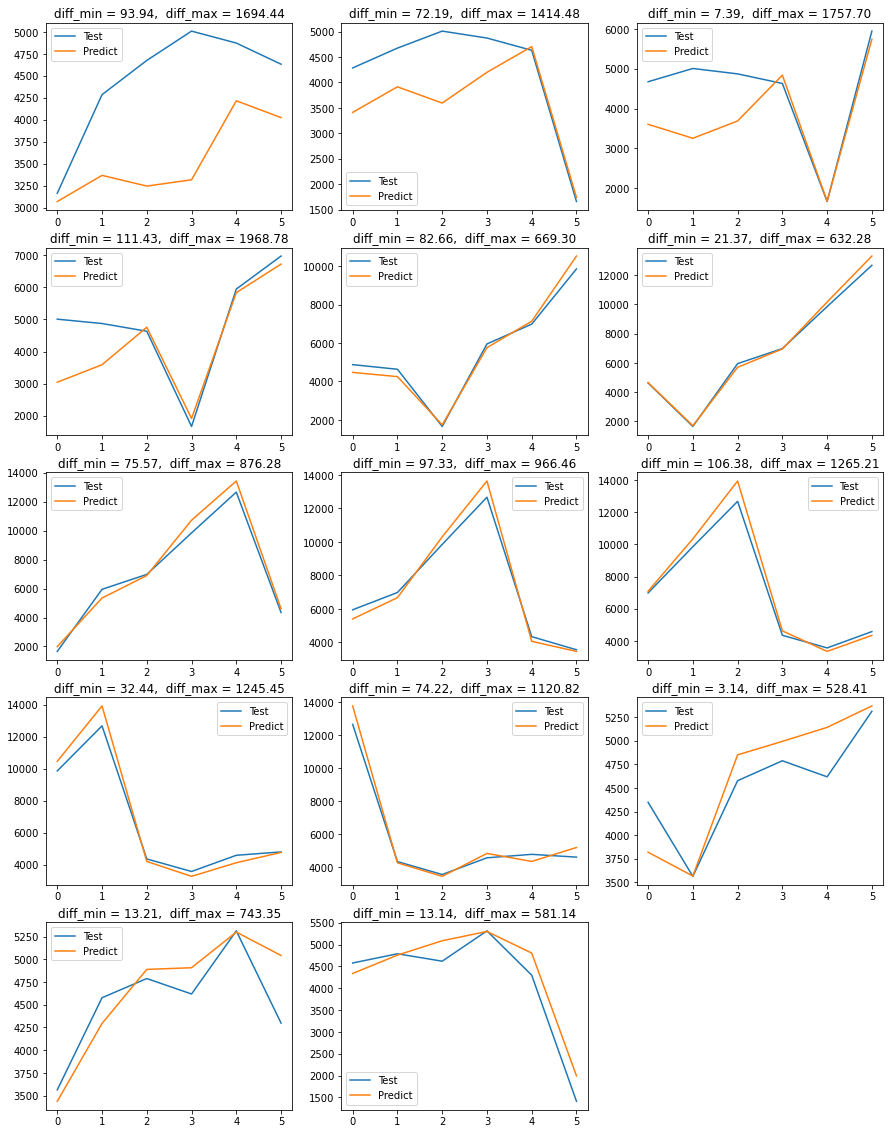

In [24]:
# 예측 값을 plot으로
cols = 3
rows = (test_y.shape[0] / cols) + 1

pyplot.figure(figsize=(15, 20))
for i in range(test_y.shape[0]):
    pyplot.subplot(rows, cols, i+1)
    pyplot.plot(test_y[i], label="Test")
    pyplot.plot(prediction[i], label="Predict")
    pyplot.legend()
    
    min_val = min(abs(test_y[i] - prediction[i]))
    max_val = max(abs(test_y[i] - prediction[i]))
    title = 'diff_min = ' + '%.2f' % min_val + ',  ' + 'diff_max = ' + '%.2f' % max_val   
    pyplot.title(title)
    
pyplot.show()

## 성능 분석
* Auto ARIMA 성능과 비교해 볼 것

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate forecasts
rmse = sqrt(mean_squared_error(test_y, prediction))
print('RMSE: %.3f' % rmse)

RMSE: 646.850


In [26]:
from sklearn.metrics import r2_score

r2_score_ret = r2_score(test_y, prediction)
print('R2 Score: %.5f' % r2_score_ret)

R2 Score: 0.94094
